In [7]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime

from sklearn.linear_model import LinearRegression

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


import arch
from arch import arch_model

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yfin
yfin.pdr_override()


import warnings

In [8]:
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
plt.rcParams["figure.figsize"] = (10,6)

#sk.set_config(display='diagram')
warnings.filterwarnings("ignore")

# Assignment

1. Create a time series for an asset in your portfolio, one which exhibits heteroskedasticity, over a period of the previous year based on end of day closing price.
2. Implement an ARCH/GARCH model in Python (or another language of your choosing)
3. Apply the model to the time series that you have created and use it to model the asset risk for the next 10 market days
4. Post your results here and summarize them on a discussion board thread.
5. Upload you code and libraries to the GitHub classroom

## Variables

In [9]:
start = datetime.datetime(2022, 10, 1)
split_date = datetime.datetime(2023,8,24)
today = datetime.datetime(2023,10,20)

## Functions

In [10]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

# Load Data

For this analysis I will focus on the following AI stocks:
- ARKK - ARK Innovation ETF
- EXAS - Exact Sciences Corporation 
- NVTA - Invitae Corporation
- PATH - UiPath Inc. 
- TWLO - Twilio Inc.

This is a sector that we are targeting as part of the investment strategy so focusing these stock is consistent with the broader portfolio strategy.

In [11]:
sp_list = ['ARKK','EXAS','NVTA','PATH','TWLO']

df = pdr.get_data_yahoo(sp_list, period='1y')['Close']
percent_df = df.pct_change().dropna()
percent_df.describe()

[*********************100%%**********************]  5 of 5 completed


,ARKK,EXAS,NVTA,PATH,TWLO
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.000953,0.002863,-0.003539,0.002671,0.001544
std,0.028517,0.033828,0.062124,0.039744,0.034998
min,-0.065423,-0.117275,-0.218605,-0.111995,-0.126429
25%,-0.017574,-0.014758,-0.047200,-0.023047,-0.017690
50%,-0.000904,-0.002097,-0.010640,0.002452,-0.001527
75%,0.017485,0.018526,0.032111,0.026765,0.020527
max,0.145226,0.246451,0.364035,0.176229,0.163073


## Graph Stockprice

<b>1. Create a time series for an asset in your portfolio, one which exhibits heteroskedasticity, over a period of the previous year based on end of day closing price.</b>

The first step in the analysis is to create a timeseries graph of a few stocks in the portfolio looking for a stock that exibits heteroscedasticity over the past year. The percentage change graph for TWLO shows changes in variance across the portfolio timeframe.


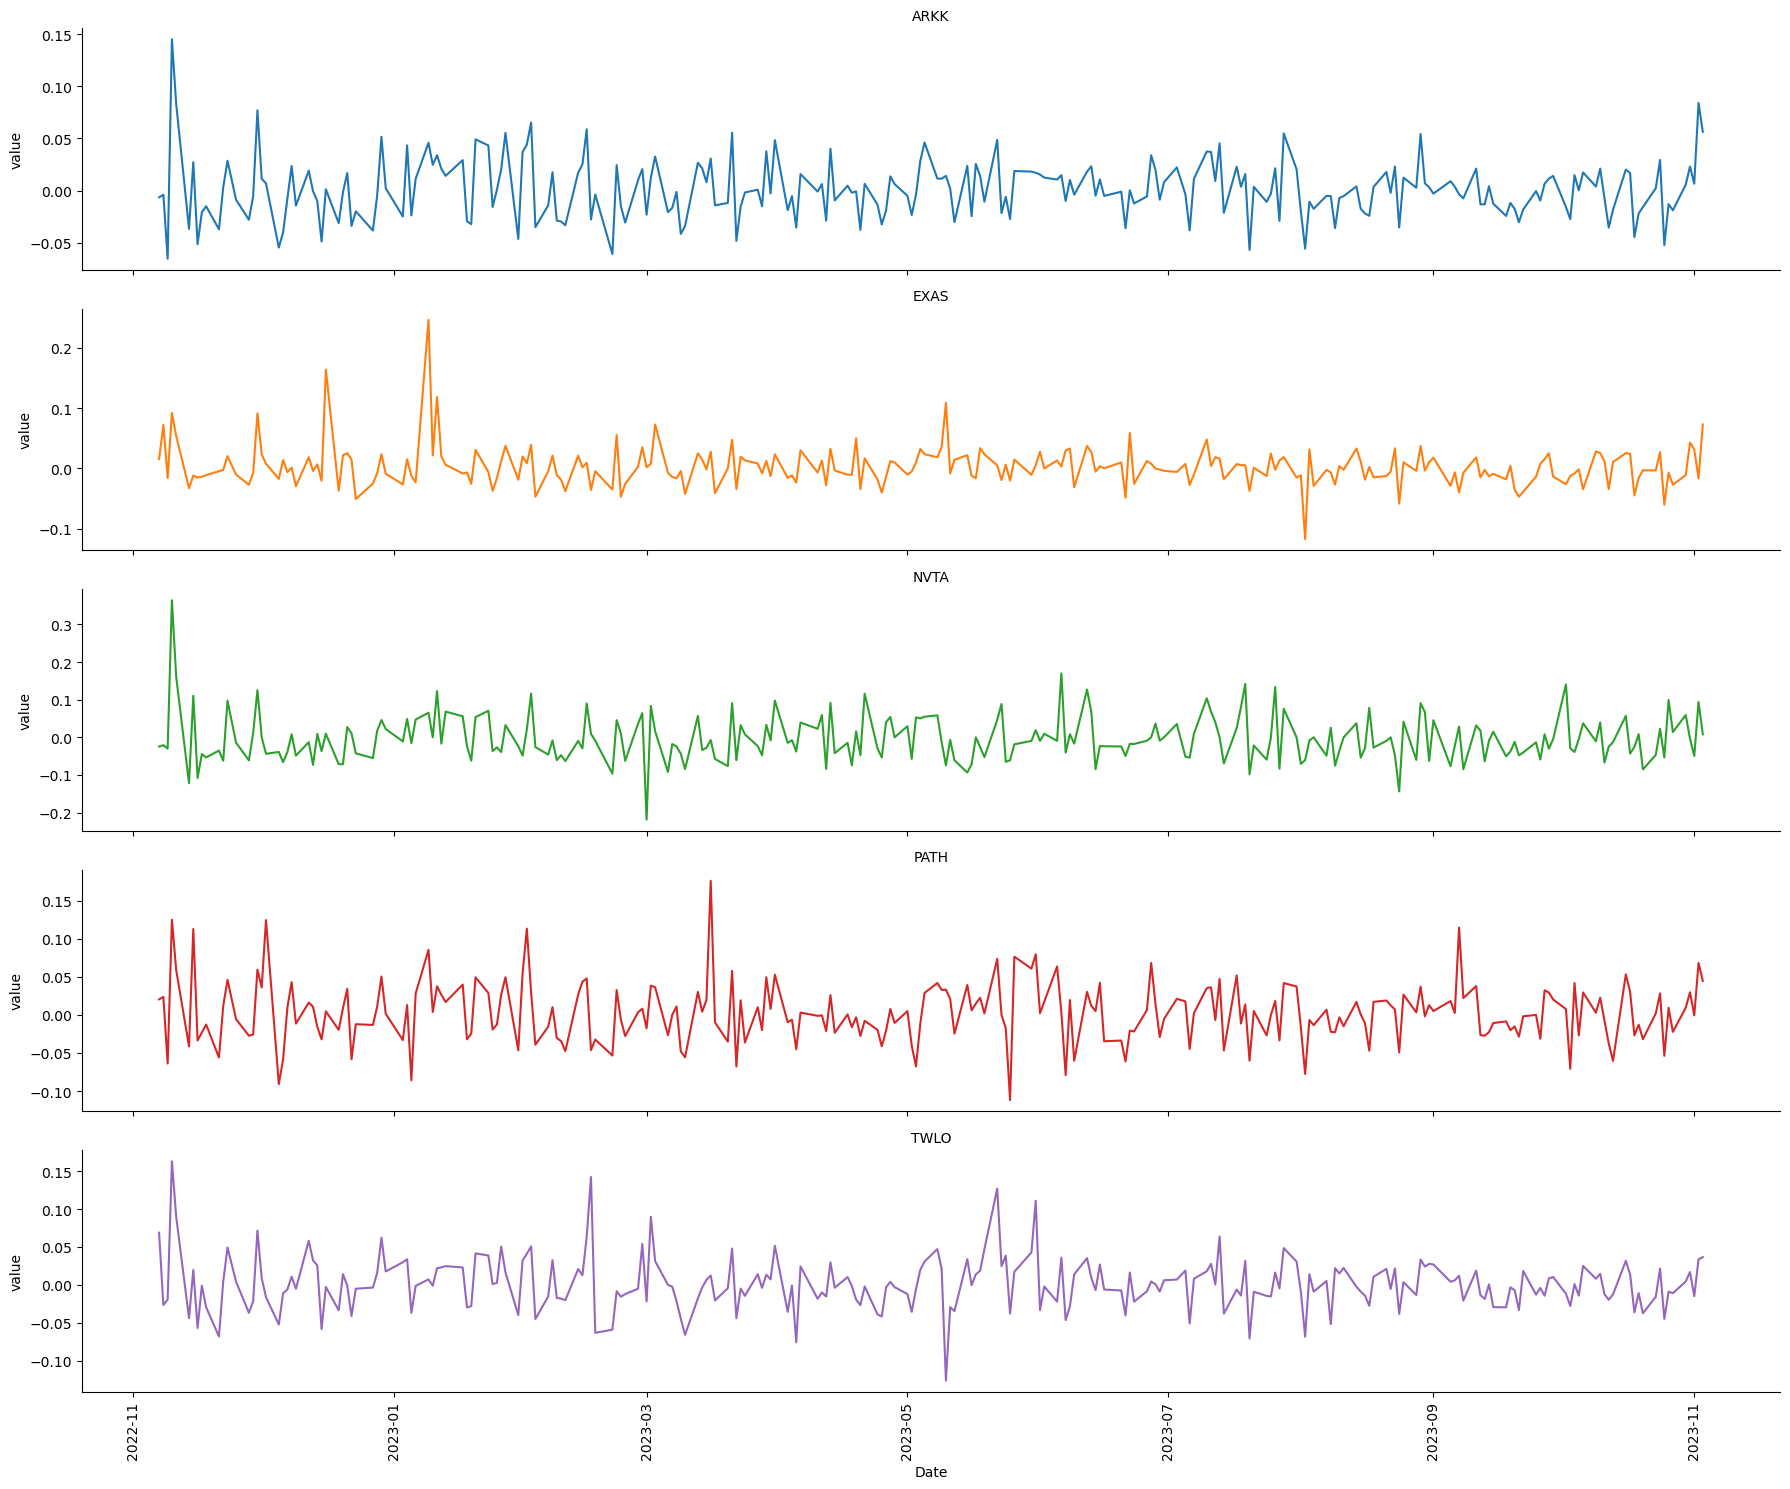

In [12]:
long_df = percent_df.copy()
long_df.reset_index()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['Date'])

# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=6,col_wrap=1, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="Date")

_ = plt.show()


## Augmented Dickey-Fuller Test for Times Stationality

- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
- HA: The time series is stationary.

The p-value is not less than 0.05 so we fail to reject the Null hypothesis the time series does not have a constant variance

In [13]:
ad_fuller(df['TWLO'])

Dickey-Fuller Test indicates:
Test Statistic                 -1.797500
p-value                         0.705963
#Lags Used                      5.000000
Number of Observations Used   245.000000
dtype: float64


<br>

The returns or the percentage change from the previous day appear to be stationary based on the Dickey-Fuller test.

In [14]:
ad_fuller(percent_df[['TWLO']])

Dickey-Fuller Test indicates:
Test Statistic                 -8.481938
p-value                         0.000000
#Lags Used                      4.000000
Number of Observations Used   245.000000
dtype: float64


# SARIMA Model

Building a SARIMA model for the daily return I start by splitting the data into a training and a testing dataframe. 

- Step 1 prepare the train and test data for the model

In [15]:
splt_index = round(df.shape[0] * 0.8)
train_df = df[:splt_index].copy()
train_df = train_df.asfreq(freq='1d', how='start', method='ffill', fill_value=0)
train_df.fillna(method='ffill', inplace=True)
print('train_df:' , train_df.shape)

train_df: (294, 5)


In [16]:
y_train = train_df[['TWLO']]
y_train
print('y_train:' , y_train.shape)

y_train: (294, 1)


In [17]:
test_df = df[splt_index:].copy()
test_df = test_df.asfreq(freq='1d', how='start', method='ffill', fill_value=0)
test_df.fillna(method='ffill', inplace=True)
test_df
print('test_df:' , test_df.shape)

test_df: (71, 5)


In [18]:
y_test = test_df[['TWLO']]
y_test
print('y_test:' , y_test.shape)

y_test: (71, 1)


<br>

- Step 2 - Build the model - The summary of the automated model is a SARIMAX(1,0,0). The automated solution selected a single difference for the stock returns.

In [37]:
s_idx = len(train_df)
e_idx = s_idx + len(test_df) - 1

# initialize and fit model
model = sm.tsa.SARIMAX(y_train, trend='c')
result_model = model.fit(disp=False)

# display results
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TWLO   No. Observations:                  294
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -590.110
Date:                Sun, 05 Nov 2023   AIC                           1186.219
Time:                        14:43:38   BIC                           1197.270
Sample:                    11-04-2022   HQIC                          1190.645
                         - 08-24-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4101      0.629      2.243      0.025       0.178       2.642
ar.L1          0.9751      0.011     87.842      0.000       0.953       0.997
sigma2         3.2098      0.143     22.390      0.000       2.929       3.491
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               340.67
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.73
Prob(H) (two-sided):                  0.53   Kurtosis:                         8.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
train_result = result_model.get_prediction(start=-s_idx, dynamic=False)
train_pred_SARIM = train_result.summary_frame()[1:]
print('train_pred_SARIM: ', train_pred_SARIM.shape)

test_result = result_model.get_prediction(start=s_idx, end=e_idx, dynamic=False)
test_pred_SARIM = test_result.summary_frame()[1:]
print('test_pred_SARIM: ', test_pred_SARIM.shape)

train_pred_SARIM:  (293, 4)
test_pred_SARIM:  (70, 4)


<br><br>

The forcasted stock prices for TWLO based on a SARIMAX model appear in the figure below. The out of sample predicted stock prices revert to a simple estimate (not quite a straight line). 

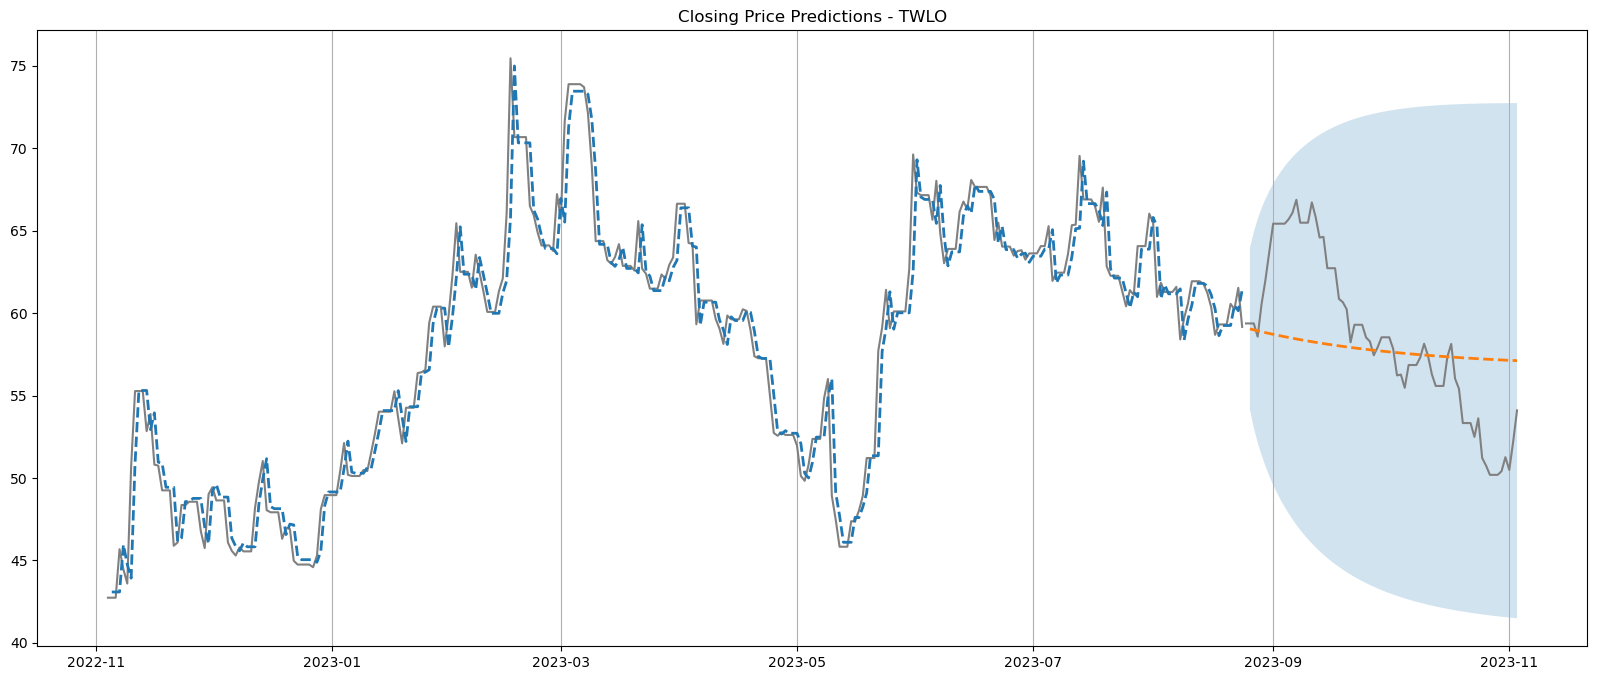

In [39]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(y_train.index, y_train['TWLO'], 'gray')
ax.plot(y_test.index, y_test['TWLO'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, test_pred_SARIM['mean_ci_lower'], test_pred_SARIM['mean_ci_upper'], alpha=0.20)

ax.set(title='Closing Price Predictions - TWLO');

<br><br>

# GARCH Model

The summary for the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is presented below. The R-squared and Adj R-squared are 0 but it is important to note that the concept of R-squared and Adj R-squared does not directly apply to GARCH models, as it is commonly used in linear regression models.

- MU - However, the p-value for MU is greater than the significance level of 0.05, so we will fail to reject the null hypothesis for MU and assume it is equal to 0. The average returns in the time series include 0 in the 95% confidence range, so we can conclude that the return of the time series is not significantly different from zero.
- Omega - the p-value suggests that there is a baseline volatility level for returns 1.3374
- Alpha - based on the p-value, is not statistically significant. The auto-regressive component of the returns does not influence the current variance
- Beta - is statistically significant based on the p-value. The moving average component of the returns does influence the current variance.

In [26]:
# create result datframe
results_df = pd.DataFrame()


# load stock and calculate returns
stock_df = pdr.get_data_yahoo('TWLO', period='1y')[['Close']]
returns = 100 * stock_df['Close'].pct_change().dropna()
print('returns',returns.shape)

# initialize and fit the arch model
model = arch_model(returns, vol='Garch')
res = model.fit(last_obs=split_date, disp='off')

# summary
print(res.summary())

[*********************100%%**********************]  1 of 1 completed
returns (250,)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -540.588
Distribution:                  Normal   AIC:                           1089.18
Method:            Maximum Likelihood   BIC:                           1102.35
                                        No. Observations:                  199
Date:                Sun, Nov 05 2023   Df Residuals:                      198
Time:                        14:26:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------------------------------

<br>

The standard diagnostic plots for the GARCH model show decreasing annualized conditional volatility and residual plot that appears to be stationary.

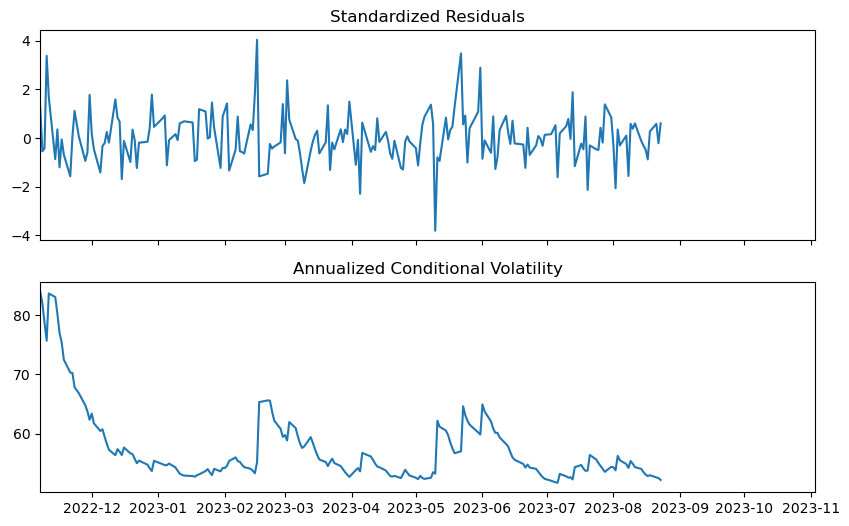

In [27]:
fig = res.plot(annualize='D')
plt.show()

<br>

The forecasted daily return volatility for TWLO using the 10 day horizon is graphed below. The mean will not be graphed since it is not statistically significant. The return variance for TWLO is in the 11.5% - 11.95% range which is a significant daily forcast. 

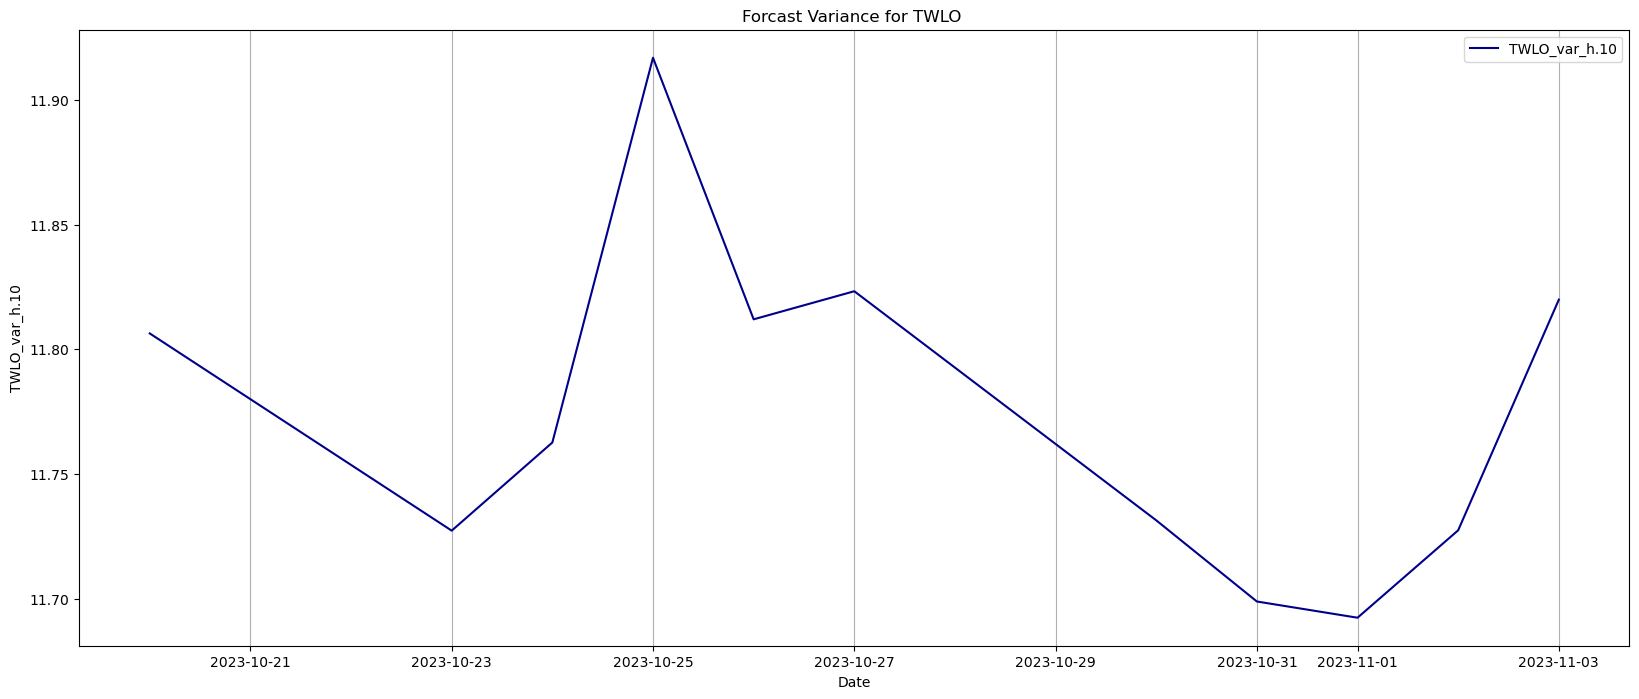

In [28]:
# Forecasting
forecasts = res.forecast(horizon=10, start=today, method='simulation')
results_df['TWLO_var_h.10'] = forecasts.variance[today:]['h.10']
results_df['TWLO_mean_h.10'] = forecasts.mean[today:]['h.10']

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()
g = sns.lineplot(x = 'Date', y = 'TWLO_var_h.10', data=results_df, label='TWLO_var_h.10', color='darkblue')
plt.ticklabel_format(style='plain', axis='y')
ax.set(title='Forcast Variance for TWLO ');

<br>

## SP500 Index

For reference we look at the same analysis using the SPY Index. The resulting forcasted variance is much lower that variance that was forecasted for TWLO (11.686% - 11.896%) vs SPY (0.324% - 0.330%)

In [29]:
# load index data and calculate returns
idx_df = pdr.get_data_yahoo('SPY', period='1y')[['Close']]
print('stock_df',idx_df.shape)
returns = 100 * idx_df['Close'].pct_change().dropna()

# initialize and fit the model
model = arch_model(returns, vol='Garch')
res = model.fit(last_obs=split_date, disp='off')
print(res.summary())

[*********************100%%**********************]  1 of 1 completed
stock_df (251, 1)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -265.138
Distribution:                  Normal   AIC:                           538.277
Method:            Maximum Likelihood   BIC:                           551.450
                                        No. Observations:                  199
Date:                Sun, Nov 05 2023   Df Residuals:                      198
Time:                        14:26:09   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------------------

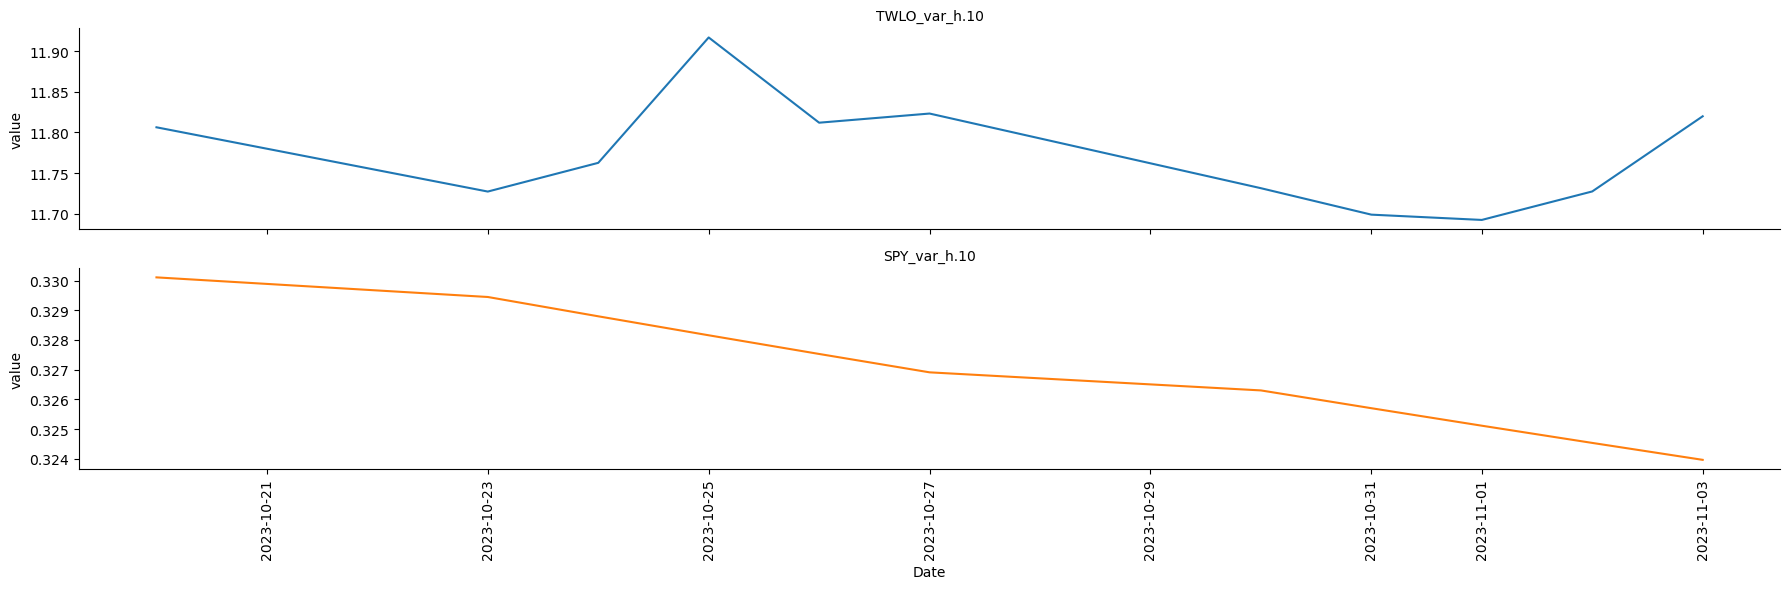

In [30]:
# forcast SPY
forecasts = res.forecast(horizon=10, start=today, method='simulation')
forecasts.variance[today:]

# Build results graph
results_df['SPY_var_h.10'] = forecasts.variance[today:]['h.10']
results_df['SPY_mean_h.10'] = forecasts.mean[today:]['h.10']
results_df

# Graph
long_df = results_df[['TWLO_var_h.10','SPY_var_h.10']].copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['Date'])

g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=6,col_wrap=1, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="Date")

plt.show()